In [35]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio openai-whisper spacy


In [36]:
import whisper
import gradio as gr
import spacy
import re

In [37]:
model = whisper.load_model("base")

In [61]:
# nlp = spacy.load("en_core_web_sm")

In [62]:
def extract_instructions(sentence):
    sentence = sentence.lower()

    up_matches = re.findall(r'up by (\d+(?:\.\d+)?)\s*meters?', sentence)
    forward_matches = re.findall(r'forward by (\d+(?:\.\d+)?)\s*meters?', sentence)
    backward_matches = re.findall(r'backward by (\d+(?:\.\d+)?)\s*meters?', sentence)

    up_distances = [float(distance) for distance in up_matches]
    forward_distances = [float(distance) for distance in forward_matches]
    backward_distances = [float(distance) for distance in backward_matches]

    return forward_distances, backward_distances, up_distances

In [63]:
def transcribe_and_process(audio_path):
    result = model.transcribe(audio_path)
    transcription = result['text']

    forward_distances, backward_distances, up_distances = extract_instructions(transcription)

    response = []
    for up_distance in up_distances:
        response.append(f"Flying up by {up_distance} meters")
    for forward_distance in forward_distances:
        response.append(f"Moving forward by {forward_distance} meters")
    for backward_distance in backward_distances:
        response.append(f"Moving backward by {backward_distance} meters")

    if response:
        response = ", then ".join(response) + "."
    else:
        response = "No movement instruction detected."

    print(f"Command: {response}")
    return transcription, response

In [64]:
iface = gr.Interface(
    fn=transcribe_and_process,
    inputs=gr.Audio(type="filepath"),
    outputs=[gr.Textbox(label="Transcription"), gr.Textbox(label="Command")],
    title="Robot Control Command Transcriber",
)

In [65]:
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://815e79e919e71edcf6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


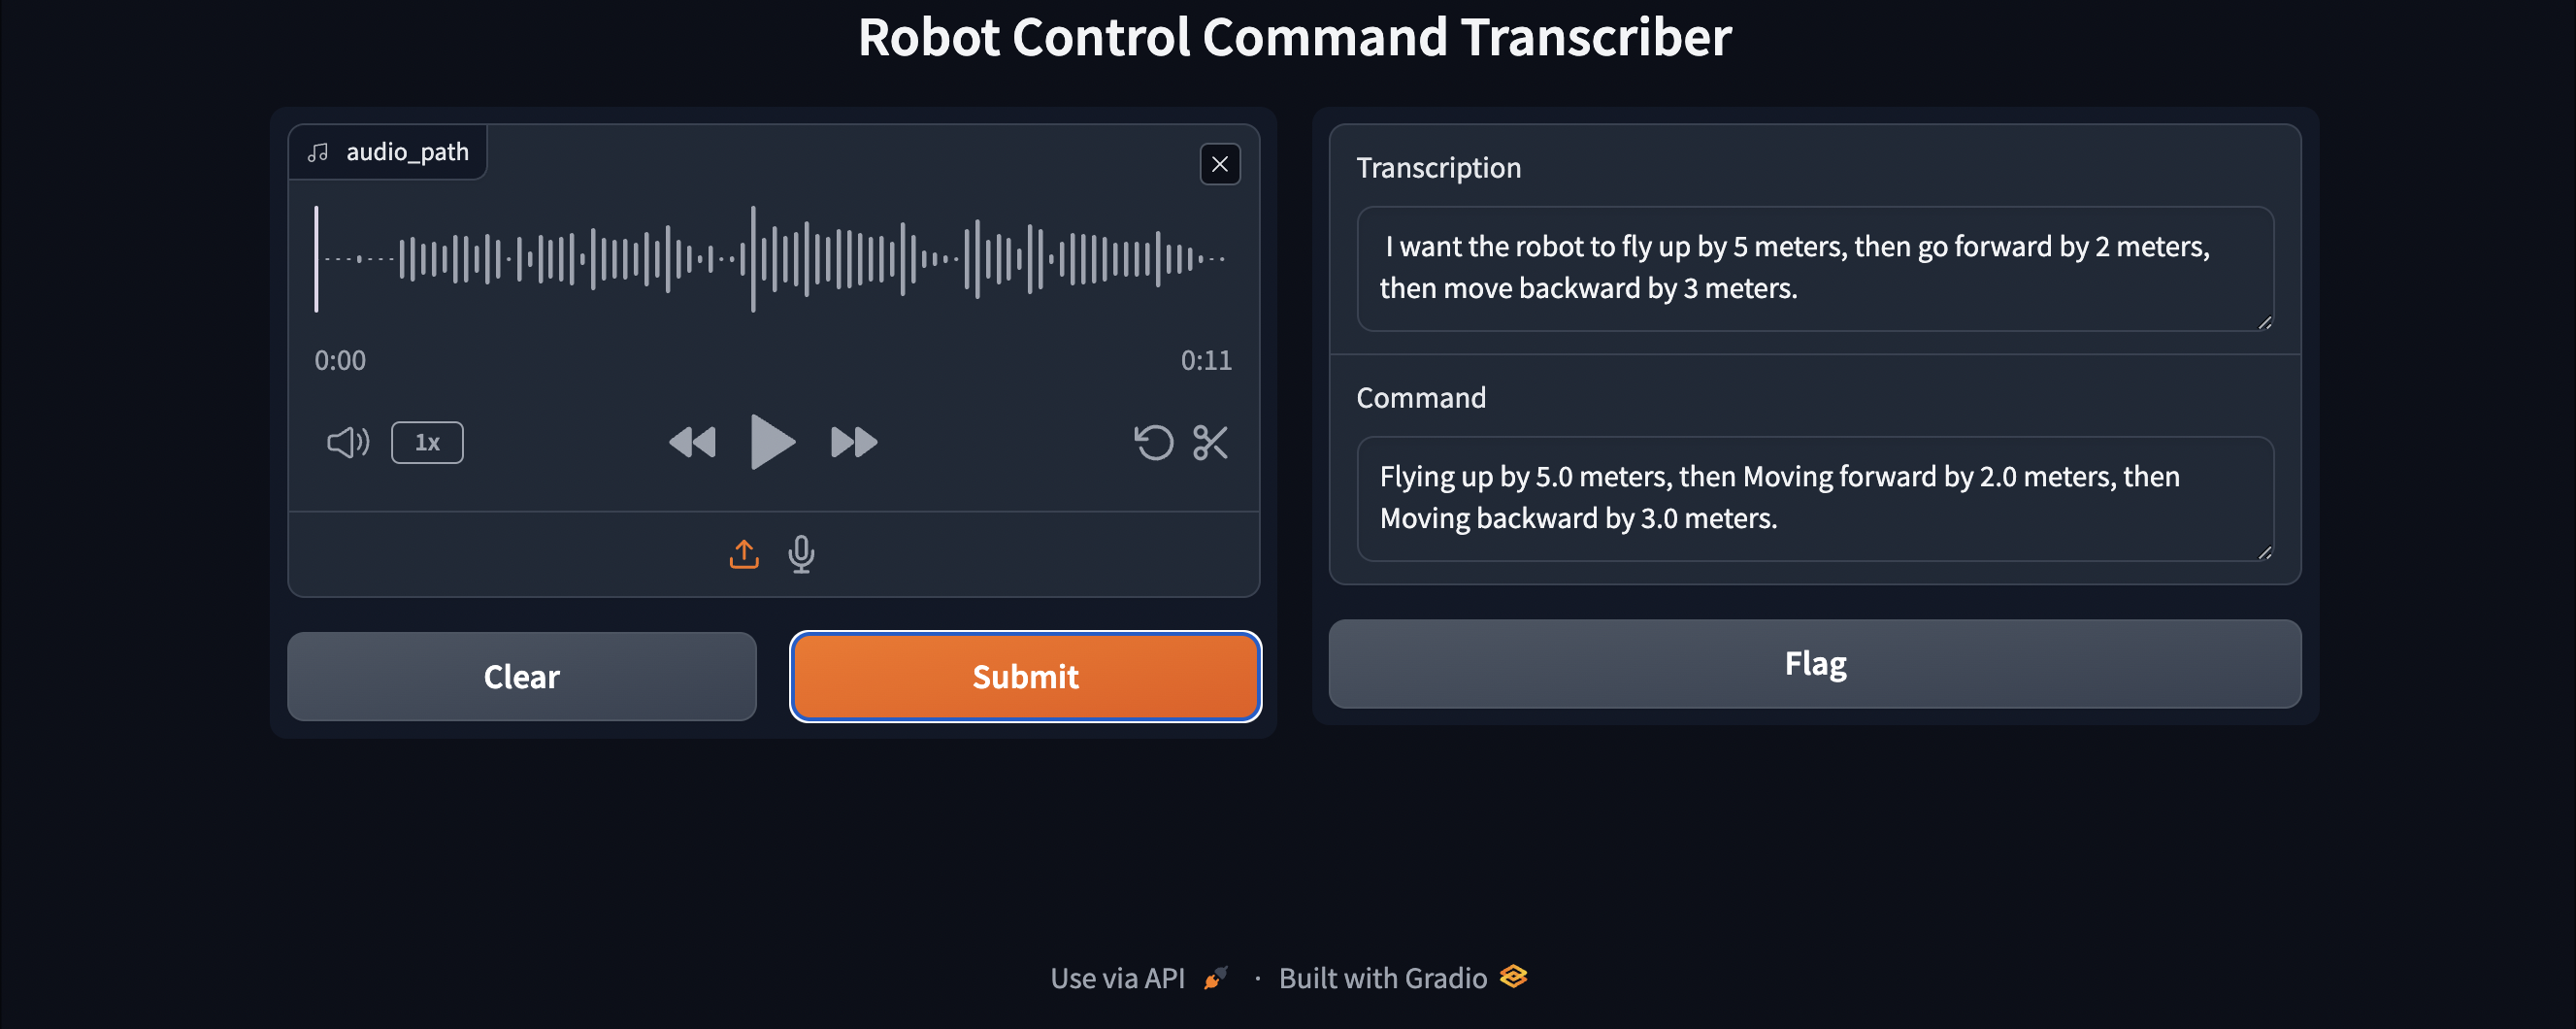